In [108]:
# # 支出方向关键词

EXPENSE_KEYWORDS = {
    'human': ['人大监督', "教育", "培训", "人才", "高校", "学生", "师资", "学校", "教学", "助学", "办学", "实习", "科研", "创新", "科普",
    "学前教育", "义务教育", "职业教育", "高等教育", "继续教育", "留学", "奖学金", "助学金", "教师", "毕业生",
      # 人员相关支出
    "正常履职", "履职支出", "履职经费",  # 人员工作保障
    "经费类支出", "人员经费", "公用经费",  # 人员相关费用
    
    # 管理与服务
    "绩效评价", "资金评价", "优化分配",  
    "预算管理", "资金管理", "财务管理",  
    
    # 社会服务
    "社会投资带动", "社会资本引导",  
    
    # 医疗健康与社会保障
    "医疗", "卫生", "健康", "医院", "医保", "养老", "保险", "社保", "救助", "低保", "福利", "残疾人", "优抚",
    "疫情防控", "公共卫生", "医疗服务", "药品", "护理", "康复", "体检", "妇幼保健", "疾病预防", "职业病",
    
    # 劳动就业
    "就业", "创业", "失业", "招聘", "职业技能", "岗位", "劳务", "再就业", "就业援助", "就业服务", "人力资源",
    
    # 民生与公共管理
    "工资", "薪酬", "津贴", "补贴", "补助", "生活费", "绩效", "奖金", "社区", "服务", "社工", "信访", "调解",
    "公共管理", "社会治理", "公共安全", "应急", "救助", "志愿服务",
    
    # 文化体育
    "文化", "体育", "旅游", "娱乐", "文物", "非遗", "博物馆", "图书馆", "健身", "运动员", "教练员", "赛事", "活动",
    
    # 科技人才
    "研发", "科技人才", "工程师", "科学家", "博士后", "技术人才", "创新团队", "科研人员", "专家",
    
    # 特定人群服务
    "妇女", "儿童", "青少年", "老年人", "退役军人", "农民工", "流动人口", "贫困人口", "受灾群众", "特殊教育",'节能减排及环境保护',
'林业改革',
'水务改革',
'普惠金融发展专项资金',

# === 彩票与公益金 ===
'公益金', '彩票',

# === 国企改革与结构调整（制度性支出）===
'解决历史遗留问题及改革成本',
'国有企业改革成本支出',
'国有经济结构调整支出',
'技术进步支出',     
# 一般公共服务与治理
'人大监督', '委员视察', '信访事务',
'知识产权战略', '知识产权规划',

# 气象服务（属于公共服务，保障人民生命财产安全）
'气象服务', '其他气象事务支出',

# 住房保障（保障居住权，属于民生）
'住房租赁市场发展', '城乡社区住宅', '其他城乡社区住宅支出',

# 物资储备（粮食、能源储备本质是保障民生安全，而非基建）
'粮油物资储备', '粮油物资事务', 
'能源储备', '成品油储备',
'重要商品储备', '其他重要商品储备支出',

# 应急管理与救援（核心是保障人的生命安全）
'应急管理事务', '安全监管', '应急管理',
'消防救援事务', '其他消防救援事务支出',
'地震事务',

# 财务管理（债务维持）
'债务付息支出', '债务发行费用支出',
# === 新增：气象 ===
'气象服务', '其他气象事务支出',

# === 新增：住房保障 ===
'住房租赁市场发展', '城乡社区住宅', '其他城乡社区住宅支出',

# === 新增：储备类（民生保供）===
'粮油物资储备支出',
'粮油物资事务', '能源储备预算', '成品油储备',
'重要商品储备', '其他重要商品储备支出',

# === 新增：应急管理 ===
'应急管理事务', '安全监管', '应急管理',
'消防救援事务', '其他消防救援事务支出',
'地震事务',
          # === 新增：农林水（管理类）===
 '水利', '水土保持', '水资源节约管理与保护',
 '水文测报', '其他水利支出',
 '林业草原防灾减灾',
 
 # === 新增：产业与商业服务（制度性支持）===
 '资源勘探工业信息等支出',
 '资源勘探开发', '制造业',
 '工业和信息产业监管', '其他工业和信息产业监管支出',
 '支持中小企业发展和管理支出',
 '其他资源勘探工业信息等支出',
 
 '商业流通事务', '商业流通发展支出',
 '涉外发展服务支出',
 '金融部门行政支出', '金融部门监管支出', '金融发展支出',
 '普惠金融发展支出', '创业担保贷款贴息及奖补',
 
 # === 新增：区域协作与自然资源 ===
        '援助其他地区支出',
        '自然资源海洋气象等支出',
        '自然资源事务', '自然资源规划及管理',
        
        
        # === 财政科目类 ===
        '一般公共服务','民贸','民品',
        '人大事务', '政协事务', '政府办公厅', '发展与改革事务', '统计信息事务',
        '纪检监察事务', '审计管理', '对外贸易管理', '招商引资', '知识产权事务',
        '港澳台事务', '档案事务', '宗教事务', '民主党派', '工商联事务',
        '群众团体事务', '党委办公厅', '共产党事务', '网信事务', '网信事务支出决算',
        '其他共产党事务支出决算数', '市场监督管理事务', '食品安全', '化妆品事务',
        '公共安全', '公安', '检察', '法院', '司法', '司法行政', '监狱',
        '强制隔离戒毒', '社会治安', '一般行政管理事务', '一般行政管理事务决算',
        '行政运行', '机关服务', '事业运行', '专项业务',
        
        '科学技术支出', '财政科技支出', '科技支出',
        '科学技术管理事务', '机构运行', '基础研究', '其他基础研究支出',
        '应用研究', '其他应用研究支出', '技术研究与开发',
        '科技条件与服务', '其他科技条件与服务支出', '科学技术普及',
        '科技交流与合作', '国际交流与合作', '科技重大项目',
        '北京经济技术开发区发展支出', '中关村发展支出',
        
        '教育支出', '文化和旅游', '文物', '新闻出版电影', '广播电视',
        '文化旅游体育与传媒支出', '文化产业发展专项支出',
        '群众文化', '文化和旅游交流与合作', '文化和旅游市场管理',
        '旅游宣传', '文化和旅游管理事务', '新闻通讯', '监测监管',
        '其他广播电视支出', '文化惠民',
        
        '社会保障和就业支出',
        '民政管理事务', '其他民政管理事务支出', '抚恤', '退役安置',
        '儿童福利', '社会福利事业单位', '其他社会福利支出',
        '退役军人管理事务', '养老', '医保', '社保', '低保', '救助',
        '困难群众', '残疾人', '保障', '待遇', '公益性岗位', '失业',
        '救济', '长期护理', '护理保险',
        
        '卫生健康支出', '医疗卫生', '中医（民族医）药专项',
        '计划生育事务', '其他计划生育事务支出', '医院', '疾控', '妇幼',
        '公卫服务', '公共卫生', '疫情防控',
        
        '节能环保支出',
        '环境保护管理事务', '生态环境国际合作及履约', '污染防治',
        '固体废弃物与化学品', '能源节约利用', '生态环境监测与信息',
        '能源管理事务',
        
        '城乡社区支出', '城乡社区管理事务', '城乡社区规划与管理',
        '执业资格注册', '资质审查',
        
        '农林水支出', '农业农村',
        '统计监测与信息服务', '林业和草原', '执法与监督',
        '产业化管理', '信息管理',
        
        '商业服务业等支出', '住房保障支出', '棚户区改造', '棚改',
        '安置房', '住房保障',
        
        '灾害防治及应急管理', '预备费',

        # === 战略与政策类（侧重于人/民生的发展方向）===
        '五型经济', '先导产业', '集成电路', '生物医药', '人工智能',
        '关键核心技术', '科技小巨人', '科创板', '天使投资', '创业投资',
        '战略性未来产业', '绿色家电', '新能源汽车',
        
        # === 区域与协作 ===
        '东西部协作', '对口支援', '对口合作', '革命老区',
        '长三角一体化', '生态绿色一体化', '先行启动区',

        # === 民生与消费 ===
        '农民集中居住', '相对集中居住', '促消费', '消费券',

        # === 核心关键词 ===
        # 教育
        '教育', '教学', '教师', '学生', '助学金', '义务教育',
        '高等教育', '职教',
        # 医疗
        '医疗', '卫生',
        # 文化
        '免费开放', '图书馆', '博物馆', '体育',
        # 就业与人才
        '就业', '培训', '职业技能', '人才津贴', '引进人才', '创业扶持',
        # 补贴类
        '补贴', '补助', '奖励', '资助',
         # 从文本中提取的新关键词
    "经费支出",  # 通常指人员经费、办公经费等
    "基本支出",  # 一般包括人员经费和公用经费
    "财政事务",  # 财政管理工作涉及人员
    "税收事务",  # 税收征管人员相关
    "审计事务",  # 审计人员相关工作
    "海关事务",  # 海关人员相关工作
    "商贸事务",  # 商务贸易管理人员
    "民族工作",  # 民族事务工作人员
    "组织事务",  # 组织人事工作
    "华侨事务",  # 侨务工作人员
    "社会工作",  # 社会工作人员
    "信访业务",  # 信访工作人员
    "社会公益研究",  # 科研人员
    "社会科学",  # 社科研究人员
    "科技成果转化",  # 科技人员
    
    # 通用人员相关词汇
    "工资福利", "人员经费", "办公费", "差旅费", "会议费", "培训费", 
    "咨询费", "劳务费", "委托业务费", "公务接待费", "公务用车运行维护费",
    "离退休费", "抚恤金", "医疗费", "住房补贴", "住房公积金",
    
    # 其他人员相关
    "能力建设", "素质提升", "队伍建设", "人才培养", "人才引进",
    "专家咨询", "评审评估", "监督检查", "执法办案", "行政管理",'科技','科学','人员',
         # 从新文本中提取的明确人员相关词汇
    "离退休人员", "退休人员", "离退休",  # 人员福利
    "军队移交政府", "军队转业干部", "退役军人",  # 军人安置
    "转业干部", "军转干部",  # 军人转业
    "红十字事业",  # 人道主义工作人员
    "中医药事务",  # 中医药工作人员
    "执法监察", "执法监管",  # 执法人员
    "国有资产监管",  # 监管人员
    "金融支出",  # 金融工作人员
    
    # 人员管理与服务
    "人员安置", "干部安置", "职工安置", "人员管理",
    "机构管理", "人员服务", "干部管理", "职工管理",
    
    # 社会保障与福利
    "拥军优属", "优抚安置", "优抚工作", "抚恤优待",
    "医疗保障", "养老保险", "失业保险", "工伤保险",
    "生育保险", "住房公积金",
    
    # 其他人员相关
    "监测人员", "监测工作", "监管人员", "监管工作",
    "防治人员", "防治工作", "储备人员", "储备工作",
        
    ],

    'physical': [
         # 从文本中提取的新关键词
    "资本性支出",  # 通常指购置固定资产、基础设施建设等
    "改革成本支出",  # 可能涉及资产处置、设备更新等
    "技术进步支出",  # 可能涉及设备购置、技术引进
    "直达资金",  # 可能用于基础设施建设等项目
    
    # 资本性支出的具体类别
    "房屋建筑物购建", "办公设备购置", "专用设备购置", "交通工具购置",
    "基础设施建设", "大型修缮", "信息网络购建", "物资储备",
    "土地补偿", "安置补助", "地上附着物和青苗补偿", "拆迁补偿",
    
    # 项目投资相关
    "项目支出", "专项支出", "投资支出", "建设支出", "购置支出",
    "设备更新", "技术改造", "信息化建设", "网络建设", "系统建设",
    
    # 其他物相关
    "固定资产", "无形资产", "长期投资", "股权投资", "债权投资",
    "物资采购", "设备租赁", "房屋租赁", "场地使用", "能源消耗",
         # 基础设施与建筑工程
    "建设", "工程", "基建", "施工", "建筑", "安装", "改造", "修缮", "装修", "扩建", "新建", "改建", "重建",
    "办公楼", "厂房", "宿舍", "场馆", "道路", "桥梁", "隧道", "铁路", "机场", "港口", "码头", "车站", "管网",
    "水利", "水电", "燃气", "热力", "通信", "网络", "数据中心", "实验室", "基地", "园区", "开发区",
    
    # 设备与物资
    "设备", "仪器", "装备", "机械", "车辆", "船舶", "飞机", "器材", "工具", "家具", "用品", "材料", "物资",
    "采购", "购置", "购买", "引进", "进口", "国产化", "生产线", "装置", "系统", "软件", "硬件", "服务器",
    
    # 能源与环境
    "能源", "电力", "煤炭", "石油", "天然气", "新能源", "可再生能源", "节能", "减排", "环保", "污染治理",
    "污水处理", "垃圾处理", "废物处理", "绿化", "造林", "园林", "生态修复", "环境监测", "大气治理", "水治理",
    
    # 农业与土地
    "农业", "农田", "水利", "灌溉", "农机", "农资", "养殖", "畜牧", "渔业", "林业", "森林", "草原", "土地",
    "耕地", "宅基地", "建设用地", "土地整理", "土地复垦", "农村建设", "乡村振兴",
    
    # 产业与技术
    "产业", "工业", "制造业", "技术改造", "技术升级", "产业化", "生产线", "工厂", "车间", "仓储", "物流",
    "供应链", "产业链", "产能", "生产基地", "研发中心", "测试平台",
    
    # 城乡发展
    "城乡", "城市", "城镇", "农村", "乡村", "市政", "公用", "公共设施", "公园", "广场", "绿地", "照明",
    "排水", "供水", "供电", "供气", "供热", "环卫", "保洁", "市容", "环境整治",
    
    # 特定项目
    "信息化", "数字化", "智能化", "智慧城市", "交通枢纽", "物流中心", "仓储设施", "实验装置", "科研设施",
        
        # === 产业与基建项目 ===
        '公路水路运输', '其他公路水路运输支出', '邮政业支出',
        '轨道交通支出',
        # 基础设施
        '基础设施', '道路', '桥梁', '管网', '污水处理', '垃圾处理',
        '绿化', '亮化', '农田水利', '高标准农田', '交通运输',
        # 城市环境
        '环卫',
        
        # 建设与工程
        '建设', '改造', '修缮', '征地拆迁',
        # 设备与资产
        '购置', '设施', '仪器设备', '车辆', '标准化厂房',
        
        # 新型基建与数字化硬件
        '智慧城市', '大数据中心', '新基建', '5G', '数据中心',
        # 物流与农业基建
        '仓储物流', '网络建设', # 从新文本中提取的明确物相关词汇
    "质量基础",  # 可能涉及质量标准、检测设备等
    "自然生态保护", "生态保护",  # 环境保护设施
    "自然保护地", "保护区",  # 保护区建设
    "生态环境",  # 环境治理设施
    "地质灾害防治", "灾害防治",  # 防灾设施建设
    "医药储备",  # 药品物资储备
    
    # 基础设施与设备
    "监测设备", "检测设备", "监控设备", "监测系统",
    "防护设施", "防治工程", "治理工程", "修复工程",
    
    # 物资与储备
    "物资储备", "药品储备", "医疗物资", "应急物资",
    "战略储备", "资源储备", "能源储备", "粮食储备",
    
    # 其他物相关
    "基础建设", "基础工程", "基础项目", "基础工作",
    "体系建设", "系统建设", "平台建设",'水质'
    ]
}


EXCLUDE_PHRASES = ['收入','调入','总支出','五型经济', '三大先导产业', '天使投资引导基金',
    '科创板', '战略性未来产业', '专项发展资金',
    '上解中央', '税收返还', '转移支付', '债务还本', '债务转贷',
    '补充预算稳定调节基金', '调出资金', '结转下年', '净结余','债',
    '支出总量', '政府性基金预算支出', '国有资本经营预算支出',
    '社会保险基金支出',
    '一般公共预算', '完成预算', '同比增长', '下降','总计', '合计', ' total ', '共安排', '政府性基金支出', '国有资本经营支出', '全年支出',
      '市级支出', '区级支出', '全市支出', 
      '使用以前年度结转资金', '安排的支出','债务付息','其他支出',
    '完成调整预算', '完成代编预算', '增长',
      "分配市级", "下达区级",  # 资金分配
    "先投快投,带动社会投资",  # 投资引导描述
    "动用预算稳定调节基金",  # 财政平衡操作
    "剔除省级应回收资金",  # 资金调整 
]

In [109]:
import os
import re
import pandas as pd

# ================== 配置 ================== 
# root_dir = os.path.dirname(os.path.abspath(''))
root_dir = os.getcwd()

# //拼接路径
BASE_DIR = os.path.join(root_dir, "reports")
OUTPUT_CSV = os.path.join(root_dir, "output", "investment_analysis.csv")
print("开始处理：报告根目录：",BASE_DIR,"输出CSV文件：", OUTPUT_CSV)
# BASE_DIR = "d:\\999-桌面\\homework\\homework\\reports"

# # BASE_DIR = "./reports"
# OUTPUT_CSV = "d:\\999-桌面\\homework\\homework\\output\\investment_analysis.csv"

# 区域映射
def get_region_label(name):
    name = name.strip()
    if "东部" in name: return "东部"
    if "中部" in name: return "中部"
    if "西部" in name: return "西部"
    return "未知区域"


YEAR_PATTERN = re.compile(r'(202[1-5])')

# 支出相关的触发词
TRIGGER_WORDS = r'(?:支出|投入|安排|拨付|用于|下达|列支|预算|决算|资金|经费|扶持|补贴|资助)'

# 金额正则（带上下文）
AMOUNT_PATTERN = re.compile(
    f'({TRIGGER_WORDS})[^\\d]*?'  # 触发词后允许非数字字符（如冒号、空格）
    r'(\d{{1,3}}(?:,\d{{3}})*(?:\.\d+)?|\d+(?:\.\d+)?)\s*(亿|万)?\s*元',
    re.IGNORECASE
) 
# 全角转半角（包括数字、字母、标点）
def full_to_half(s):
    return s.translate(str.maketrans(
        '０１２３４５６７８９ａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺ！？。',
        '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!?.' 
    ))
 

def extract_amount_and_category(sentence):
     # 全角转半角（解决北京样本问题）
    sentence = full_to_half(sentence)

        # === 第一步：排除财政调度和汇总语句 ===
    # 在函数开头加：特殊处理：“一般公共预算支出”等总述句
    if any(excl in sentence for excl in EXCLUDE_PHRASES):
        return None, None, None    
        # === 第二步：提取金额 ===

    """从句子中提取金额（转为“万元”）和支出类别"""
    match = AMOUNT_PATTERN.search(sentence)
    if not match:
        return None, None, None
    
    
       # match.group(1) 是触发词（如“支出”），我们不需要
    num_str = match.group(2).replace(',', '')
    unit = match.group(3) or ''
    
        # 先清理逗号（即使正则已过滤，再保险一次）
    clean_num_str = num_str.replace(',', '')
    if not re.fullmatch(r'\d+(\.\d+)?', clean_num_str):
        return None, None, None

    try:
        num = float(num_str)
        if unit == '亿':
            amount_wan = num * 10000
        elif unit == '万':
            amount_wan = num
        else:  # 单位是“元”
            amount_wan = num / 10000
    except ValueError:
        return None, None, None
    # print(f"DEBUG: sentence='{sentence}',num_str='{num_str}', unit='{repr(unit)}', num={num}")

    # === 第三步：关键词匹配 ===
  # 清理句子（去空格，便于关键词匹配）
    clean_sent = re.sub(r'\s+', '', sentence)  # 移除所有空白（包括全角/半角空格、换行）
    # clean_sent = sentence.replace(' ', '').replace('　', '')  # 全角空格
        # 优先匹配 human（因民生更常见，且避免被 physical 动词干扰）
    if "一般公共预算安排" in sentence:
        print("sent=",sentence)
        
    for kw in EXPENSE_KEYWORDS['human']:
        if kw in clean_sent:
            return amount_wan, 'human', kw

    for kw in EXPENSE_KEYWORDS['physical']:
        if kw in clean_sent:
            return amount_wan, 'physical', kw
    # 未明确的当作人TODO:
    return None,None,None
    # return amount_wan, 'human', '未明确方向'

# === 主流程 ===
all_records = []

# 获取所有 (region, city) 对
city_list = []
for region_folder in os.listdir(BASE_DIR):
    region_path = os.path.join(BASE_DIR, region_folder)
    if not os.path.isdir(region_path):
        continue
    for city_folder in os.listdir(region_path):
        city_path = os.path.join(region_path, city_folder)
        if os.path.isdir(city_path):
            city_list.append((region_folder, city_folder))

total_cities = len(city_list)
print(f"📊 共发现 {total_cities} 个城市，开始处理...\n")

print("citylist=",city_list)

for idx, (region_folder, city_folder) in enumerate(city_list, 1):
    region_path = os.path.join(BASE_DIR, region_folder)
    city_path = os.path.join(region_path, city_folder)

    region_label = get_region_label(region_folder)
    city_name = city_folder.rstrip('市')

    print(f"[{idx}/{total_cities}] 🏙️ 正在处理: {city_name} ({region_label})")

    city_records = []
    
    # 在城市循环内，先收集所有有效财政文件（按年份分组）
    yearly_files = {}  # {2023: {'budget': 'xxx.txt', 'final': 'yyy.txt'}, ...}

    # 只处理 .txt 文件
    print("city-filenames = ",os.listdir(city_path))
    for filename in os.listdir(city_path):
        if filename.startswith('.'):
            continue
        if not filename.lower().endswith('.txt'):
            continue
        # 忽略工作报告
        if "工作报告" in filename.lower():
            continue

        # filepath = os.path.join(city_path, filename)

        # 从文件名提取年份
        year_match = YEAR_PATTERN.search(filename)
        if not year_match:
            continue
        year = int(year_match.group(1))
        if year not in yearly_files:
            yearly_files[year] = {'budget': None, 'final': None}
        if "决算" in filename:
            yearly_files[year]['final'] = filename
        elif "预算" in filename:
            yearly_files[year]['budget'] = filename
    print('yearly_files=',yearly_files)
    for year, files in yearly_files.items():
    # 优先决算，其次预算
        chosen_file = files['final'] or files['budget']
        if not chosen_file:
            continue

        file_type = "财政决算报告" if files['final'] else "财政预算报告"
        filepath = os.path.join(city_path, chosen_file)

    # 读取并处理该文件（后续逻辑不变）

        # 读取 TXT 文件
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                text = f.read()
        except UnicodeDecodeError:
            try:
                with open(filepath, 'r', encoding='utf-8-sig') as f:
                    text = f.read()
            except Exception:
                print(f"  ⚠️ 编码错误，跳过: {chosen_file}")
                continue
        except Exception as e:
            print(f"  ⚠️ 读取失败: {chosen_file} | {e}")
            continue

        # 按段落分割（空行或换行）
        paragraphs = re.split(r'\n\s*\n', text)
        sentences = []
        for para in paragraphs:
            para = para.strip()
            if not para:
                continue
            # 再按中文句号、分号、感叹号、问号、换行符等分割成句子
            # 注意：避免在数字中间切（如“1.5亿元”），但中文环境下通常用“。”而非“.”
            sub_sents = re.split(r'[；;。！!？?\n\r]+', para)
            for s in sub_sents:
                s = s.strip()
                if s and len(s) >= 10:  # 过滤太短的碎片
                    sentences.append(s)
        for sentence in sentences:
            if not sentence or len(sentence) < 10 or "收入" in sentence:
                continue

            amount, cat, kw = extract_amount_and_category(sentence)
            if amount is not None and amount >= 100:  # 至少100万元
                city_records.append({
                    "区域": region_label,
                    "城市": city_name,
                    "年份": year,
                    "文件类型": file_type,
                    "支出类别": cat,
                    "匹配关键词": kw,
                    "原文片段": sentence[:250].replace('\n', ' '),
                    "金额（万元）": round(amount, 2),
                    "页码": None,
                    "文件名": chosen_file
                })

    all_records.extend(city_records)
    print(f"  ✅ 完成 {city_name}，新增 {len(city_records)} 条记录，累计 {len(all_records)} 条")

    # 实时保存
    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    df = pd.DataFrame(all_records)
    df.to_csv(OUTPUT_CSV, index=False, encoding='utf_8_sig')
    print(f"  💾 已保存至: {OUTPUT_CSV}\n")

开始处理：报告根目录： d:\999-桌面\homework\homework\reports 输出CSV文件： d:\999-桌面\homework\homework\output\investment_analysis.csv
📊 共发现 18 个城市，开始处理...

citylist= [('东部地区', '上海市'), ('东部地区', '北京市'), ('东部地区', '广州市'), ('东部地区', '杭州市'), ('东部地区', '济南市'), ('东部地区', '深圳市'), ('东部地区', '苏州市'), ('中部地区', '南昌市'), ('中部地区', '合肥市'), ('中部地区', '武汉市'), ('中部地区', '洛阳市'), ('中部地区', '郑州市'), ('中部地区', '长沙市'), ('西部地区', '南宁市'), ('西部地区', '咸阳市'), ('西部地区', '成都市'), ('西部地区', '自贡市'), ('西部地区', '西安市')]
[1/18] 🏙️ 正在处理: 上海 (东部)
city-filenames =  ['.DS_Store', '.~市2021年预算.docx', '.~市2022年市级决算.docx', '.~市2025年预算.docx', '2021上海市政府工作报告.docx', '2021上海市政府工作报告.txt', '2022上海市政府工作报告.docx', '2022上海市政府工作报告.txt', '2023上海市政府工作报告.docx', '2023上海市政府工作报告.txt', '2024上海市政府工作报告.docx', '2024上海市政府工作报告.txt', '2025年上海市政府工作报告.docx', '2025年上海市政府工作报告.txt', '上海市2021年市级决算.docx', '上海市2021年市级决算.txt', '上海市2021年预算.docx', '上海市2021年预算.txt', '上海市2022年市级决算.docx', '上海市2022年市级决算.txt', '上海市2022年预算.docx', '上海市2022年预算.txt', '上海市2023年市级决算.docx', '上海市2023年市级决算.txt', '上海市2023年预算.docx

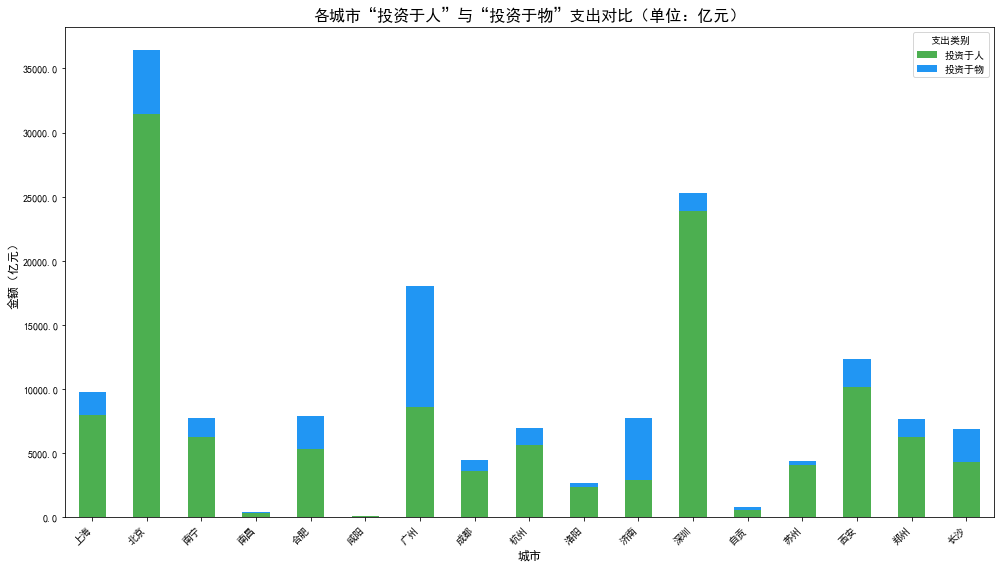

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import os

plt.rcParams['font.sans-serif'] = [
    'PingFang SC',
    'Heiti SC',
    'SimHei',
    'Arial Unicode MS'
]
 

# 读取数据
root_dir = os.getcwd()

# //拼接路径
OUTPUT_CSV = os.path.join(root_dir, "output", "investment_analysis.csv")
df = pd.read_csv(OUTPUT_CSV)

# 只保留有金额的记录（排除定性分析行）
df_amount = df.dropna(subset=['金额（万元）'])

# 将“万元”转换为“亿元”用于显示（1 亿元 = 10000 万元）
df_amount['金额（亿元）'] = df_amount['金额（万元）'] / 10000

# 按城市和类别汇总（单位：亿元）
city_totals = df_amount.groupby(['城市', '支出类别'])['金额（亿元）'].sum().unstack(fill_value=0)

# 绘图
ax = city_totals.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=['#4CAF50', '#2196F3']  # human: green, physical: blue
)

# 设置标题和标签
plt.title('各城市“投资于人”与“投资于物”支出对比（单位：亿元）', fontsize=16)
plt.xlabel('城市', fontsize=12)
plt.ylabel('金额（亿元）', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['投资于人', '投资于物'], title='支出类别')

# 格式化 Y 轴：保留1位小数
from matplotlib.ticker import FuncFormatter
def billions(x, pos):
    return f'{x:.1f}'
ax.yaxis.set_major_formatter(FuncFormatter(billions))

plt.tight_layout()
plt.show()

In [111]:
import os   
root_dir = os.path.dirname(os.path.abspath('.'))
print(os.getcwd())
print(root_dir)
# //拼接路径
BASE_DIR = os.path.join(root_dir, "reports")
OUTPUT_CSV = os.path.join(root_dir, "output", "investment_analysis.csv")
print(BASE_DIR, OUTPUT_CSV)



d:\999-桌面\homework\homework
d:\999-桌面\homework
d:\999-桌面\homework\reports d:\999-桌面\homework\output\investment_analysis.csv
